In [1]:
!pip install praw pandas seaborn scipy

In [2]:
import csv
from datetime import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
from typing import Callable

from config import Config, CONFIG_FILE_NAME
from util import *
import validate

sns.set_theme()

In [3]:
# To ensure everything's nice and deterministic
random.seed(0)
np.random.seed(0)

In [4]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [5]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [13]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

In [5]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [6]:
runs = get_runs()
missing_runs = validate.missing_runs(runs.keys())
assert len(missing_runs) == 0, missing_runs

In [7]:
df = load_comments(*runs.values())
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151671549,2009-12-31 19:01:19,IAmA,NaN,t3_ak9ne,t3_ak9ne,2,0,How often do you deal with patient's nightmare...
1,26151671809,2009-12-31 19:06:01,WTF,3hk2x,t3_akagz,t3_akagz,6,0,Just moved to Florida this year when my husban...
2,26151671837,2009-12-31 19:06:34,IAmA,3p98v,t1_c0i01vs,t3_ak5n9,3,0,If I had a son and I saw him getting paid to f...
3,26151672754,2009-12-31 19:21:08,funny,3oimh,t1_c0i13gh,t3_akcbo,3,0,Yeah I guess it is larry miller. http://www.ad...
4,26151672788,2009-12-31 19:21:44,trees,3mj2p,t3_akbbc,t3_akbbc,2,0,OxyClean
...,...,...,...,...,...,...,...,...,...
1900010,33418663200,2019-12-31 18:39:04,videos,14cwr7,t3_ei3zx5,t3_ei3zx5,-4,0,It's not so much the names that are funny but ...
1900011,33418693376,2019-12-31 18:46:49,GonewildGBUK,57nk6h9s,t3_ei9vhh,t3_ei9vhh,0,0,Well if you need an extra cock in 2020 😜😈😈happ...
1900012,33418700835,2019-12-31 18:48:40,unpopularopinion,g8vguuw,t3_ei2udf,t3_ei2udf,1,0,It's also a stereotype that kids visit each pa...
1900013,33418710516,2019-12-31 18:51:06,AskReddit,lp3bf,t3_eiauoe,t3_eiauoe,2,0,"More ass, better ass"


In [8]:
misses = load_misses(*runs.values())
misses

149445    26151671597
120293    26151671665
104026    26151672225
279973    26151672735
229323    26151672783
             ...     
16785     33418443272
251723    33418501316
41975     33418553272
75558     33418632879
355612    33418643877
Length: 390185, dtype: int64

In [9]:
# Sanity checks
validate.validate(df, misses)

✅ Found no duplicate comment IDs
✅ Found no duplicate misses
❌ Found out-of-order IDs (call validate.find_out_of_order_ids for more info)
Bad rows:
                id                time sr_name author_id parent_fullname  \
48111  26160647523 2010-04-02 12:35:08     WTF     3on4x        t3_blm3i   
48112  26160647528 2010-04-02 12:35:06  canada      wlho      t1_c0ndbjm   

        post_id  upvotes  downvotes  \
48111  t3_blm3i        2          0   
48112  t3_blidv        2          0   

                                                    body  
48111  I just want to point out that depending on how...  
48112  >I am for fairly strong HANDGUN laws, especial...  
Found issues:
- Found out-of-order IDs


In [10]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, to_b36(first_id_actual)

(26151671549, 'c0i12wt')

In [11]:
config = Config.load(os.path.join(runs[len(runs) - 1], CONFIG_FILE_NAME))
config.start_date

datetime.date(2010, 1, 1)

#### Actual analysis

In [14]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [15]:
df[BODY] = df[BODY].map(lambda body: body.lower().strip())
matched_rows = df[df[BODY].map(matches)]
matched_rows

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
5,26151672838,2009-12-31 19:22:36,politics,38gp5,t3_akdh9,t3_akdh9,5,0,"""recovery""\n\nhow... ironic. limbaugh was ""tak..."
42,26151678996,2009-12-31 21:17:35,AskReddit,32hft,t3_aka68,t3_aka68,3,0,"1. you use the word 'cult', which obviously ha..."
139,26151696244,2010-01-01 04:32:09,AskReddit,3ofl5,t3_akadq,t3_akadq,1,0,hey thanks this is pretty sweet!!\n\ni'm not s...
176,26151703955,2010-01-01 09:50:08,self,3cs90,t3_akgyf,t3_akgyf,3,0,i back all this shit - \n\nand being one of th...
231,26151714823,2010-01-01 14:03:15,reddit.com,3svvz,t3_akks9,t3_akks9,1,0,my toonstorm.com review\n\ni am addicted to wo...
...,...,...,...,...,...,...,...,...,...
1899735,33415989588,2019-12-31 08:43:04,Libertarian,54y5eyk,t1_fcmzpho,t3_ehyabi,18,0,"well by that argument, drinking and driving sh..."
1899738,33416013315,2019-12-31 08:50:41,de,NaN,t3_ei2v2v,t3_ei2v2v,13,0,es gibt keine wirklich gute lösung für das pro...
1899847,33417044810,2019-12-31 12:51:45,stormbound,2i9j8gjh,t1_fcmygqz,t3_ei2mxg,2,0,"i'm level 13 and hardstucked at gold3, my most..."
1899854,33417090423,2019-12-31 13:00:43,AmItheAsshole,55gpprzc,t3_ei14kf,t3_ei14kf,5,0,"nta, but i don’t think your father is either. ..."


In [16]:
{
    keyword: len(matched_rows[matched_rows[BODY].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 940,
 'gaslight': 105,
 'trigger': 2837,
 'toxic': 1818,
 'woke': 1452,
 'manipulat': 1755,
 'microaggression': 7,
 'autis': 774,
 'adhd': 386,
 'ocd': 359,
 'ptsd': 381,
 'bipolar': 296,
 'anxiety': 1786,
 'depress': 4099,
 'psycho': 3330,
 'delusion': 986,
 'delulu': 2,
 'solulu': 1,
 'addict': 2706,
 'abus': 4694,
 'unstable': 434,
 'narcissis': 422,
 'neurodivergen': 0}

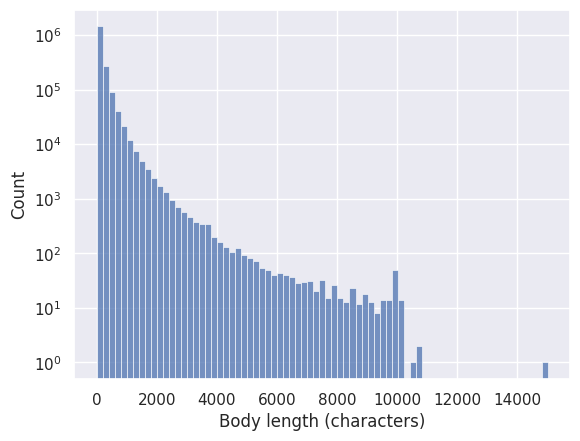

In [17]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths, # lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [18]:
df[lengths >= 10000]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
81436,26168375763,2010-06-12 18:14:08,MensRights,NaN,t1_c0rz3vc,t3_ce9j0,2,0,**catlebrity**:\n\n* [father wouldn't give di...
139828,26183543585,2010-09-30 15:58:14,apple,4dh8y,t3_dl0nz,t3_dl0nz,-10,0,####################################### ...
196697,26203296431,2011-01-14 15:33:18,MensRights,4o06h,t3_f26rp,t3_f26rp,0,0,">""womens rights"" evolved due to the oppression..."
238823,26221694521,2011-04-04 03:29:10,AskReddit,2hx7a,t3_gi46q,t3_gi46q,48,0,getting by is easy. getting rich is hard. wo...
385417,26330172358,2012-01-11 20:19:23,gaming,6ceos,t3_ocad9,t3_ocad9,1,0,*and here's another good one!*\n\nyou're now c...
418152,26365273273,2012-03-15 00:52:34,movies,5vuli,t1_c4176fa,t3_qwpwd,24,0,"you're*\n\nand you're close, but it should rea..."
426430,26374179385,2012-03-29 22:54:45,IAmA,79fzc,t1_c46i71j,t3_rk4y6,1,0,[**kpereira**](http://www.reddit.com/r/iama/co...
605651,26653907296,2013-03-10 09:20:51,MUWs,94bog,t3_1a0hax,t3_1a0hax,2,0,below are the word frequencies from the past m...
716472,26886697592,2013-10-08 15:14:24,jobs,bvz1s,t1_ccnmalp,t3_1nx0km,2,0,"well, most of that is hype. there are laws in ..."
746241,26959812505,2013-12-06 13:00:49,femalefashionadvice,e8d24,t3_1s8ob2,t3_1s8ob2,22,0,"i’ve been lurking for a long time, and it’s in..."


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

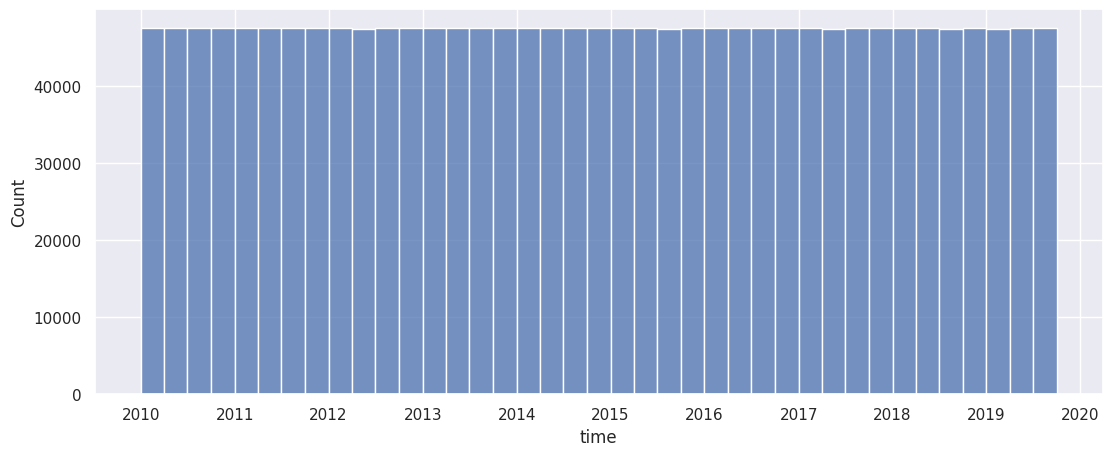

In [19]:
plt.figure(figsize=(13, 5))
sns.histplot(
    data=df,
    x=TIME,
    bins=[
        mpl.dates.date2num(time_range.start_date) for time_range in config.time_ranges
    ],
)

<Axes: xlabel='time', ylabel='Count'>

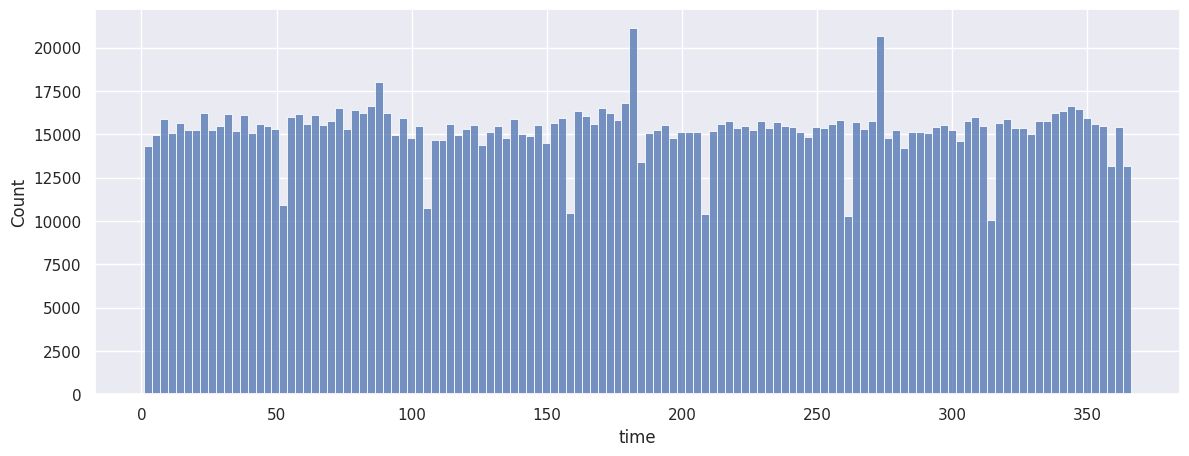

In [20]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

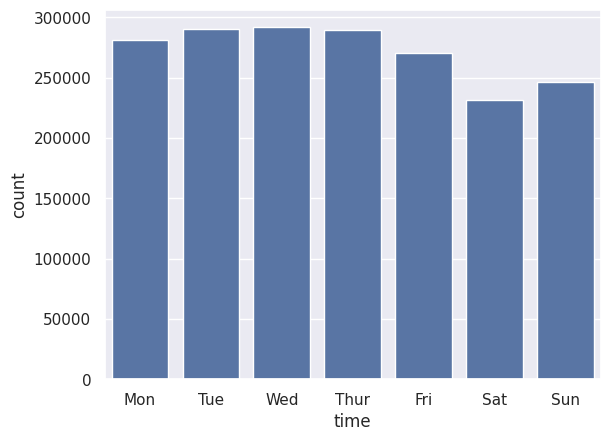

In [21]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

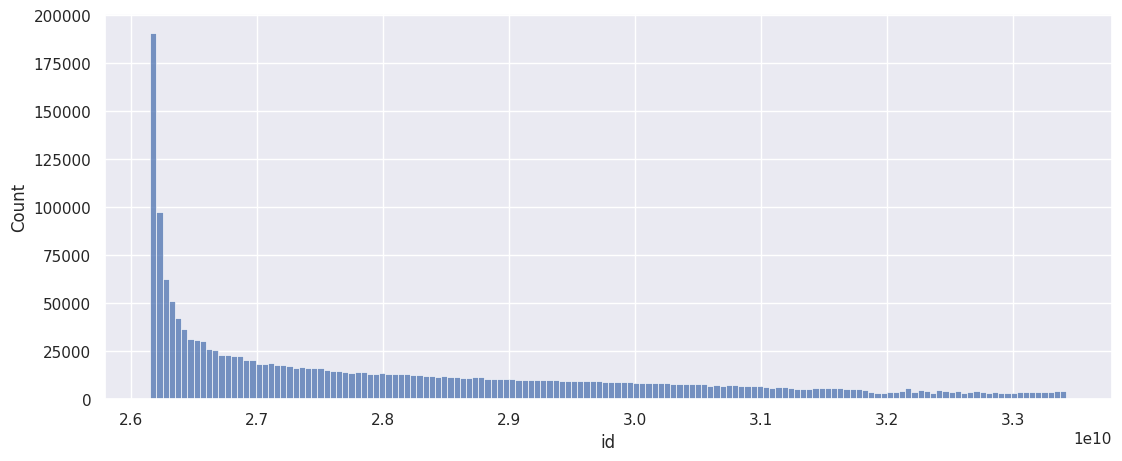

In [22]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df[ID])

In [23]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df[ID].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.6435951280762526, pvalue=0.0, statistic_location=0.29181538184077443, statistic_sign=1)

In [24]:
# The earliest comment we have
df[df[ID] == df[ID].min()]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151671549,2009-12-31 19:01:19,IAmA,NaN,t3_ak9ne,t3_ak9ne,2,0,how often do you deal with patient's nightmare...


<Axes: >

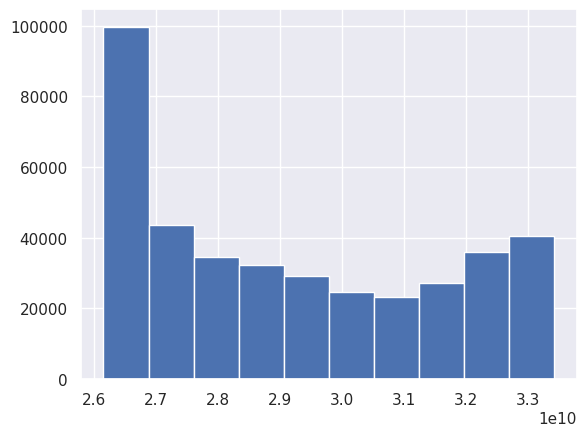

In [25]:
misses.hist()

<Axes: ylabel='Count'>

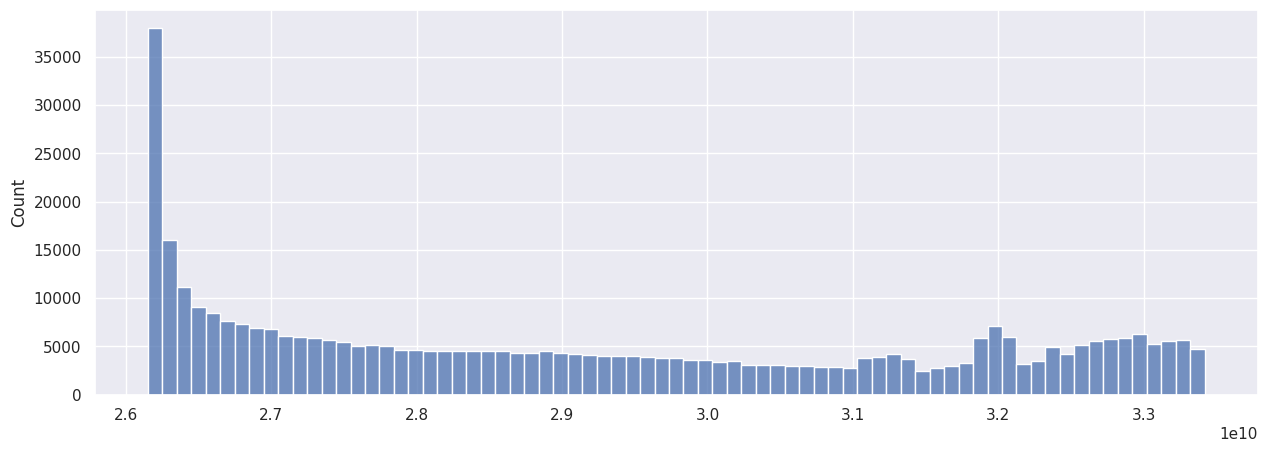

In [26]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

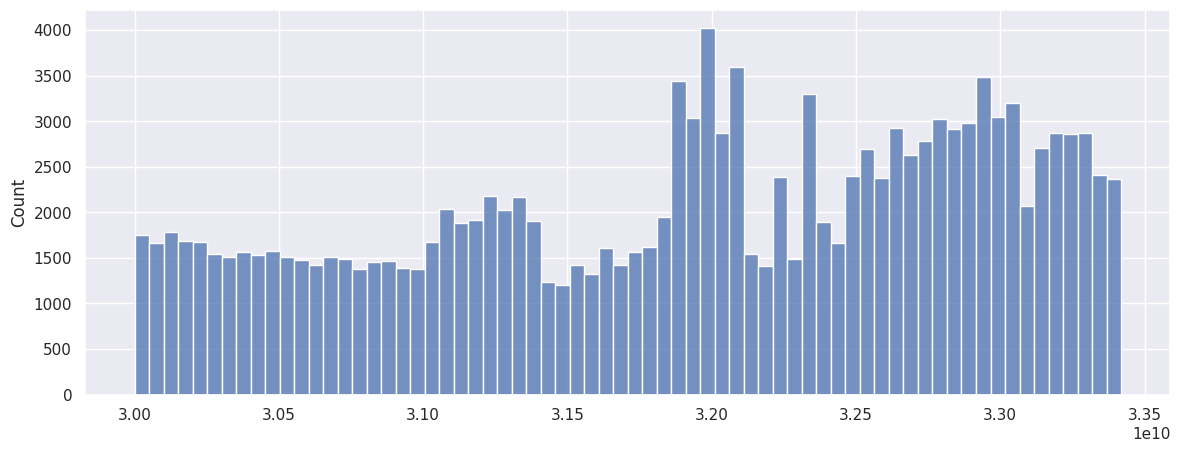

In [27]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [28]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8296284167321631, 0.8296284167321631)

<Axes: xlabel='id', ylabel='rate'>

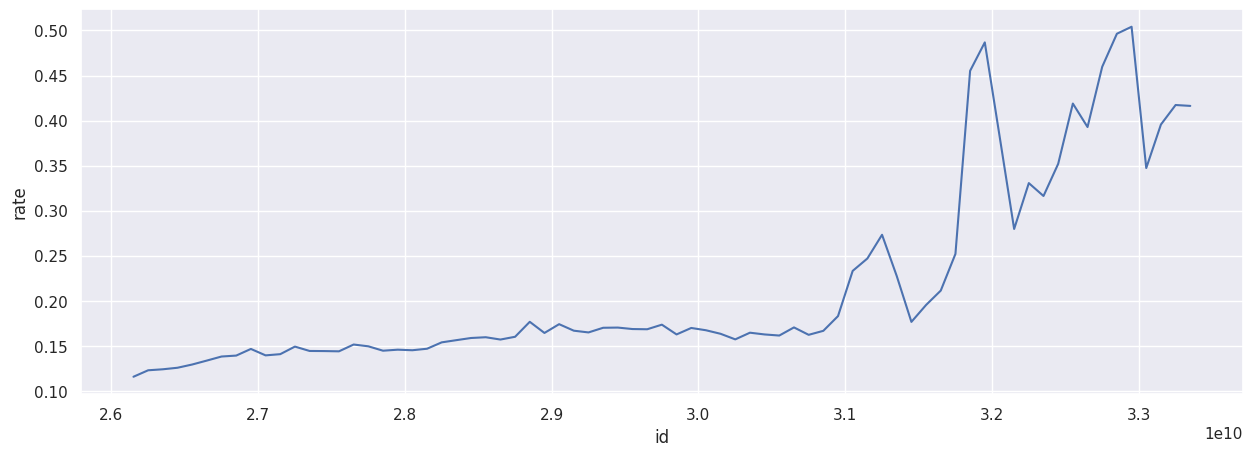

In [29]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [30]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
1521313,30000000548,2018-01-03 15:46:31,CrappyDesign,kq14w,t3_7nwcxp,t3_7nwcxp,1,0,"i'm a bot, *bleep*, *bloop*. someone has linke..."
1521314,30000000648,2018-01-03 15:46:33,news,hpdj7,t1_ds54x1y,t3_7nuf0p,1,0,"> which is appointed by the mayor, i presume. ..."
1521315,30000004473,2018-01-03 15:47:54,RaiBlocks,ap05j,t3_7nxj2h,t3_7nxj2h,1,0,the consensus so far has been that the raibloc...
1521316,30000008262,2018-01-03 15:49:13,fireemblem,yplc2,t3_7nx5nt,t3_7nx5nt,28,0,"some of these actually fit, like saber's and i..."
1521317,30000009293,2018-01-03 15:49:34,conspiracy,o10qosf,t1_ds57b7x,t3_7nwklc,1,0,thank you
...,...,...,...,...,...,...,...,...,...
1900010,33418663200,2019-12-31 18:39:04,videos,14cwr7,t3_ei3zx5,t3_ei3zx5,-4,0,it's not so much the names that are funny but ...
1900011,33418693376,2019-12-31 18:46:49,GonewildGBUK,57nk6h9s,t3_ei9vhh,t3_ei9vhh,0,0,well if you need an extra cock in 2020 😜😈😈happ...
1900012,33418700835,2019-12-31 18:48:40,unpopularopinion,g8vguuw,t3_ei2udf,t3_ei2udf,1,0,it's also a stereotype that kids visit each pa...
1900013,33418710516,2019-12-31 18:51:06,AskReddit,lp3bf,t3_eiauoe,t3_eiauoe,2,0,"more ass, better ass"


In [32]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = (misses_actual - misses_actual.mean()) / misses_actual.std()

res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.10711272388471044, pvalue=0.0, statistic_location=-0.673022862009497, statistic_sign=1)

## Subreddits

In [33]:
df[df[SR_NAME] == "reddit.com"]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
12,26151673760,2009-12-31 19:38:15,reddit.com,1rzbg,t1_c0i141e,t3_akci3,7,0,i read it as lupus. i need glasses.
16,26151674830,2009-12-31 19:57:29,reddit.com,NaN,t1_c0i0vz1,t3_ak8iy,30,0,>that's just not cool.\n\nyes it was. you simp...
17,26151674897,2009-12-31 19:58:41,reddit.com,1ntom,t3_ak95a,t3_ak95a,1,0,i currently live in an area where twc will be ...
38,26151677781,2009-12-31 20:54:20,reddit.com,3k5dq,t1_c0i0tpe,t3_ak7g4,0,0,it's hard to figure out what's right or wrong ...
39,26151677962,2009-12-31 20:57:39,reddit.com,3c7h2,t3_ak4yj,t3_ak4yj,5,0,oh my god. a book has the word narwhal in it!!...
...,...,...,...,...,...,...,...,...,...
346446,26294850892,2011-10-28 17:37:25,reddit.com,5kdvp,t1_c2snvq4,t3_j6kft,1,0,im a slow person
348873,26296954303,2011-11-02 17:09:59,reddit.com,4w480,t3_lbnva,t3_lbnva,1,0,"wait! i got this!\n\nspanking? no, no! wanking!"
354947,26302381341,2011-11-14 16:52:02,reddit.com,37j4,t1_c2zljbv,t3_2mg72,3,0,fibonacci[7962]\n\n`4074803477 8997284660 1798...
361473,26308157761,2011-11-27 16:41:00,reddit.com,NaN,t1_c335gf8,t3_lfaqi,1,0,and you came back to tell me this? that is kin...


In [34]:
# Most popular subreddits
df[SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit              192458
pics                    52898
funny                   41548
politics                39221
gaming                  34886
WTF                     25923
leagueoflegends         22466
reddit.com              21133
worldnews               20832
IAmA                    20358
videos                  18055
atheism                 17781
nfl                     17112
todayilearned           16838
nba                     15419
AdviceAnimals           15163
trees                   14880
soccer                  13243
fffffffuuuuuuuuuuuu     11240
news                    11234
Name: count, dtype: int64